#Разбор полетов

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.preprocessing import LabelEncoder
import json

In [ ]:
# Загрузка данных
def load_data(csv_path, image_dir):
    df = pd.read_csv(csv_path)
    image_paths = []
    
    for img_id in df['id']:
        jpg_path = os.path.join(image_dir, f"{img_id}.jpg")
        if os.path.exists(jpg_path):
            image_paths.append(jpg_path)
        else:
            png_path = os.path.join(image_dir, f"{img_id}.png")
            if os.path.exists(png_path):
                image_paths.append(png_path)
    categories = df['category'].values
    targets = df['target'].values if 'target' in df.columns else None
    return image_paths, categories, targets

In [ ]:


def remove_background(image_path):
    # Загружаем изображение
    image = cv2.imread(image_path)
    if image is None:
        return None
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    _, threshold = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY_INV)
    
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return image  
    
    largest_contour = max(contours, key=cv2.contourArea)
    
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)
    
    result = cv2.bitwise_and(image, image, mask=mask)
    
    return result

def preprocess_image(image_path, target_size=(128, 128)):
    # Убираем фон
    image = remove_background(image_path)
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    return image

In [ ]:
def create_model(input_shape, num_colors):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_colors, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

In [ ]:
train_csv_path = 'dataset_colors/train_data.csv'
train_image_dir = 'dataset_colors/train_data'
test_csv_path = 'dataset_colors/test_data.csv'
test_image_dir = 'dataset_colors/test_data'
train_image_paths, train_categories, train_targets = load_data(train_csv_path, train_image_dir)

In [ ]:
color_encoder = LabelEncoder()
train_targets_encoded = color_encoder.fit_transform(train_targets)
train_targets_onehot = tf.keras.utils.to_categorical(train_targets_encoded)

arr = []
length = len(train_image_paths)
count = 0
for path in train_image_paths:
    count += 1
    arr.append(preprocess_image(path))
    if count % 500 == 0: print(f'{count} / {length}')

train_images = np.array(arr)
arr = []

input_shape = train_images.shape[1:]
num_colors = len(color_encoder.classes_)
model = create_model(input_shape, num_colors)

model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

500 / 33303
1000 / 33303
1500 / 33303
2000 / 33303
2500 / 33303
3000 / 33303
3500 / 33303
4000 / 33303
4500 / 33303
5000 / 33303
5500 / 33303
6000 / 33303
6500 / 33303
7000 / 33303
7500 / 33303
8000 / 33303
8500 / 33303
9000 / 33303
9500 / 33303
10000 / 33303
10500 / 33303
11000 / 33303
11500 / 33303
12000 / 33303
12500 / 33303
13000 / 33303
13500 / 33303
14000 / 33303
14500 / 33303
15000 / 33303
15500 / 33303
16000 / 33303
16500 / 33303
17000 / 33303
17500 / 33303
18000 / 33303
18500 / 33303
19000 / 33303
19500 / 33303
20000 / 33303
20500 / 33303
21000 / 33303
21500 / 33303
22000 / 33303
22500 / 33303
23000 / 33303
23500 / 33303
24000 / 33303
24500 / 33303
25000 / 33303
25500 / 33303
26000 / 33303
26500 / 33303
27000 / 33303
27500 / 33303
28000 / 33303
28500 / 33303
29000 / 33303
29500 / 33303
30000 / 33303
30500 / 33303
31000 / 33303
31500 / 33303
32000 / 33303
32500 / 33303
33000 / 33303


In [10]:
# Обучение модели
model.fit(train_images, train_targets_onehot, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
833/833 ━━━━━━━━━━━━━━━━━━━━ 237s 281ms/step - accuracy: 0.3134 - loss: 2.2318 - val_accuracy: 0.4246 - val_loss: 1.8181
Epoch 2/20
833/833 ━━━━━━━━━━━━━━━━━━━━ 214s 256ms/step - accuracy: 0.4290 - loss: 1.8257 - val_accuracy: 0.4525 - val_loss: 1.7260
Epoch 3/20
833/833 ━━━━━━━━━━━━━━━━━━━━ 204s 245ms/step - accuracy: 0.4544 - loss: 1.7533 - val_accuracy: 0.4719 - val_loss: 1.7109
Epoch 4/20
833/833 ━━━━━━━━━━━━━━━━━━━━ 203s 244ms/step - accuracy: 0.4609 - loss: 1.7057 - val_accuracy: 0.4858 - val_loss: 1.6428
Epoch 5/20
833/833 ━━━━━━━━━━━━━━━━━━━━ 207s 249ms/step - accuracy: 0.4805 - loss: 1.6533 - val_accuracy: 0.4912 - val_loss: 1.6138
Epoch 6/20
833/833 ━━━━━━━━━━━━━━━━━━━━ 206s 247ms/step - accuracy: 0.4843 - loss: 1.6377 - val_accuracy: 0.5109 - val_loss: 1.5876
Epoch 7/20
833/833 ━━━━━━━━━━━━━━━━━━━━ 210s 252ms/step - accuracy: 0.4877 - loss: 1.6303 - val_accuracy: 0.5104 - val_loss: 1.5695
Epoch 8/20
833/833 ━━━━━━━━━━━━━━━━━━━━ 206s 248ms/step - accuracy: 0.4909 -

In [ ]:
# Загрузка тестовых данных
test_image_paths, test_categories, _ = load_data(test_csv_path, test_image_dir)

test_images = np.array([preprocess_image(path) for path in test_image_paths])

# Предсказание вероятностей для тестовых данных
predictions = model.predict(test_images)

color_names = color_encoder.classes_
predict_proba_list = []
for pred in predictions:
    proba_dict = {color: float(prob) for color, prob in zip(color_names, pred)}
    predict_proba_list.append(json.dumps(proba_dict, ensure_ascii=False))

# Определение цвета с максимальной вероятностью
predicted_colors = color_encoder.inverse_transform(np.argmax(predictions, axis=1))


45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step


In [12]:
# Сохранение результатов в файл submission.csv
results = pd.DataFrame({
    'id': [os.path.basename(path).split('.')[0] for path in test_image_paths],
    'category': test_categories,
    'predict_proba': predict_proba_list,
    'predict_color': predicted_colors
})
results.to_csv('submission.csv', index=False)

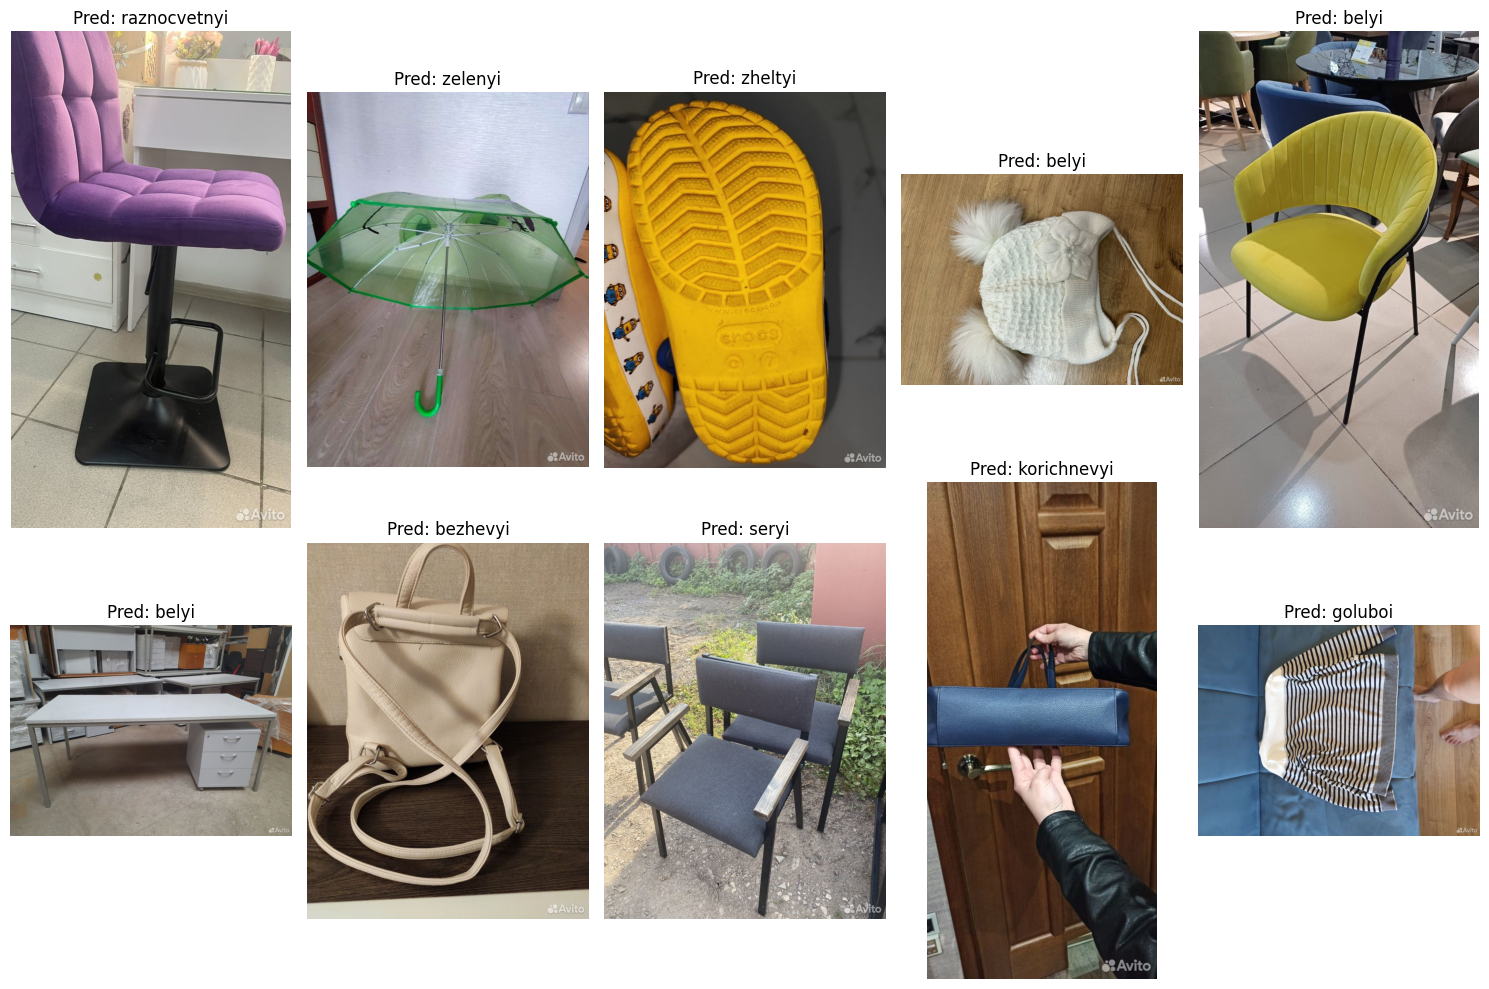

In [19]:
import matplotlib.pyplot as plt

# Вывод первых 10 тестовых изображений и их предсказанных цветов
plt.figure(figsize=(15, 10))
for i in range(30, 40):
    plt.subplot(2, 5, i - 30 + 1)
    plt.imshow(plt.imread(test_image_paths[i]))
    plt.title(f'Pred: {predicted_colors[i]}')
    plt.axis('off')  # Скрыть оси
plt.tight_layout()
plt.show()

1041/1041 ━━━━━━━━━━━━━━━━━━━━ 76s 72ms/step


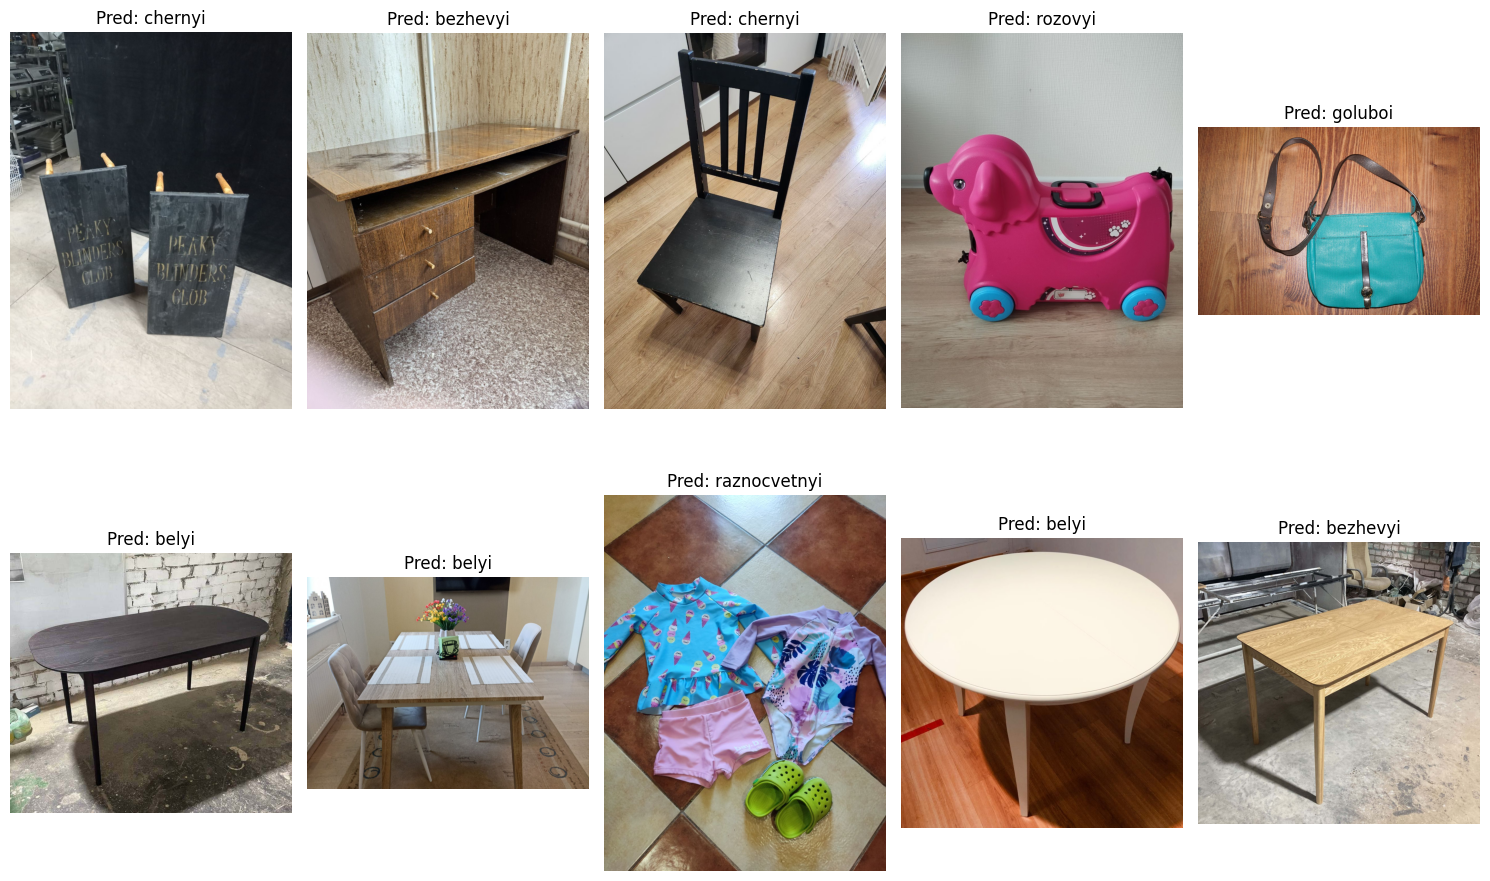

In [21]:
# Предсказание вероятностей для тестовых данных
predictions_ = model.predict(train_images)
# Вывод первых 10 тестовых изображений и их предсказанных цветов
# Определение цвета с максимальной вероятностью
predicted_colors_ = color_encoder.inverse_transform(np.argmax(predictions_, axis=1))
plt.figure(figsize=(15, 10))
for i in range(30, 40):
    plt.subplot(2, 5, i - 30 + 1)
    plt.imshow(plt.imread(train_image_paths[i]))
    plt.title(f'Pred: {predicted_colors_[i]}')
    plt.axis('off')  # Скрыть оси
plt.tight_layout()
plt.show()

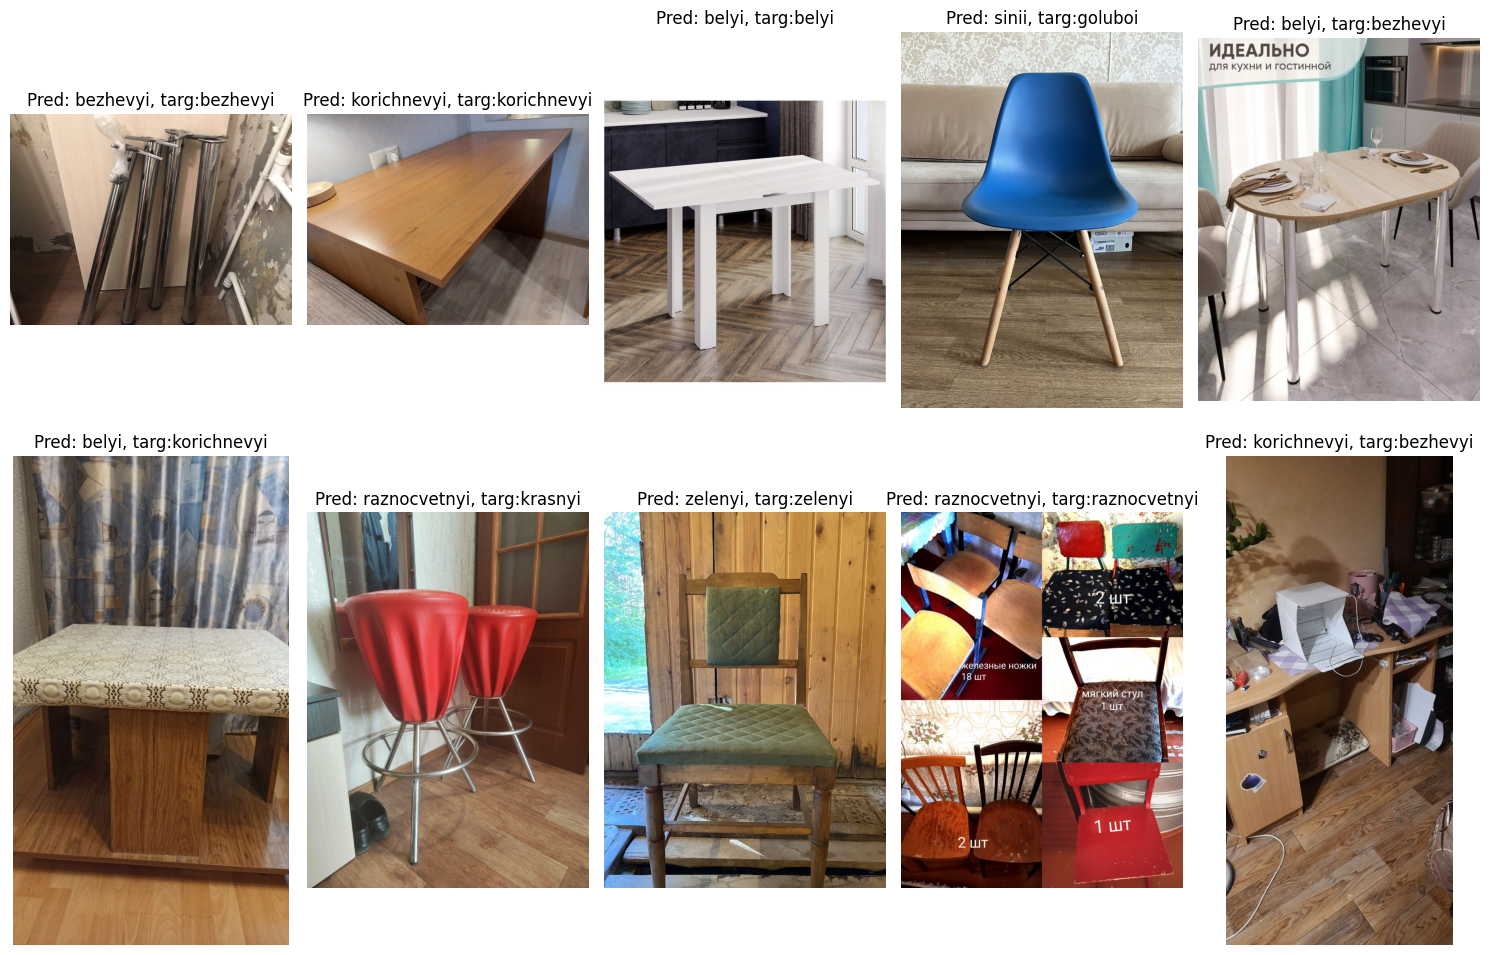

In [27]:
plt.figure(figsize=(15, 10))
start = 400
for i in range(start, start + 10):
    # print(train_targets[i])
    plt.subplot(2, 5, i - start + 1)
    plt.imshow(plt.imread(train_image_paths[i]))
    plt.title(f'Pred: {predicted_colors_[i]}, targ:{train_targets[i]}')
    plt.axis('off')  # Скрыть оси
plt.tight_layout()
plt.show()